In [99]:
import numpy
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO


In [100]:
def from_files_to_vectors(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'pos_25.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'neg_25.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_cleaned_pos"
    else:
        names = "_cleaned_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                datasets[i].append(numpy.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = numpy.array(datasets[i])
    return datasets

In [101]:
pos_datasets = from_files_to_vectors("./data_v/25_similarity/pos/", positive=True)
neg_datasets = from_files_to_vectors("./data_v/25_similarity/neg/", positive=False)

y_pos = numpy.ones(pos_datasets[0].shape[0])
y_neg = numpy.zeros(neg_datasets[0].shape[0])

In [102]:
# attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features

# keep in mind the number of virulent factors and the number of not virulent factors
rows = 0
n_pos = y_pos.shape[0]
n_neg = y_neg.shape[0]
rows = n_pos + n_neg
print('Virulent:', n_pos)
print('NON Virulent:', n_neg)

# feature vectors dimensions
columns = 0
for i in range(len(pos_datasets)):
    tmp_dim = pos_datasets[i].shape[1]
    print(i+1, '-th feature dim:', tmp_dim)
    columns += tmp_dim

# data matrix to process
X = numpy.zeros((rows, columns))
print('Data matrix dimension:', X.shape)
for i in range(n_pos):
    X[i] = numpy.concatenate([pos_datasets[j][i] for j in range(5)])
for i in range(n_neg):
    X[n_pos+i] = numpy.concatenate([neg_datasets[j][i] for j in range(5)])

Virulent: 1820
NON Virulent: 1808
1 -th feature dim: 20
2 -th feature dim: 400
3 -th feature dim: 39
4 -th feature dim: 39
5 -th feature dim: 195
Data matrix dimension: (3628, 693)


In [103]:
# permutation
numpy.random.seed(42)

y = numpy.concatenate((y_pos, y_neg), axis=0)
c = numpy.random.permutation(numpy.arange(y.shape[0]))
y = y[c]
X = X[c] 

In [104]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [105]:
# remember: standardization or scaling AFTER train-test split, otherwise there's data leakage!!!
X_train = X[:int(X.shape[0]*.5)]
X_val = X[int(X.shape[0]*.5):int(X.shape[0]*.75)]
X_test = X[int(X.shape[0]*.75):]

y_train = y[:int(y.shape[0]*.5)]
y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

print('Training data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)

print('\nTraining virulent factors and not-virulent factors:', int(sum(y_train)), int(y_train.shape[0]-sum(y_train)))
print('Validation virulent factors and not-virulent factors:', int(sum(y_val)), int(y_val.shape[0]-sum(y_val)))
print('Test virulent factors and not-virulent factors:', int(sum(y_test)), int(y_test.shape[0]-sum(y_test)))

Training data shape: (1814, 693) (1814,)
Validation data shape: (907, 693) (907,)
Test data shape: (907, 693) (907,)

Training virulent factors and not-virulent factors: 927 887
Validation virulent factors and not-virulent factors: 436 471
Test virulent factors and not-virulent factors: 457 450


In [106]:
# PCA

stdX = numpy.zeros(X_train.shape)
stdX_val = numpy.zeros(X_val.shape)
stdX_test = numpy.zeros(X_test.shape)

means = numpy.zeros(X_train.shape[1])
std_devs = numpy.zeros(X_train.shape[1])

for j in range(X_train.shape[1]):
    column = X_train[:,j]
    means[j] = numpy.mean(column)
    std_devs[j] = numpy.std(column)
    stdX[:,j] = (column - means[j]) / std_devs[j]
    stdX_val[:,j] = (X_val[:,j] - means[j]) / std_devs[j]
    stdX_test[:,j] = (X_test[:,j] - means[j]) / std_devs[j]

numpy.save('means', means)
numpy.save('std_devs', std_devs)

covariance_matrix = numpy.cov(stdX.T)

eigen_values, eigen_vectors = numpy.linalg.eig(covariance_matrix)
eigen_values = numpy.real(eigen_values)
eigen_vectors = numpy.real(eigen_vectors)

variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

cumulative_variance_explained = numpy.cumsum(variance_explained)

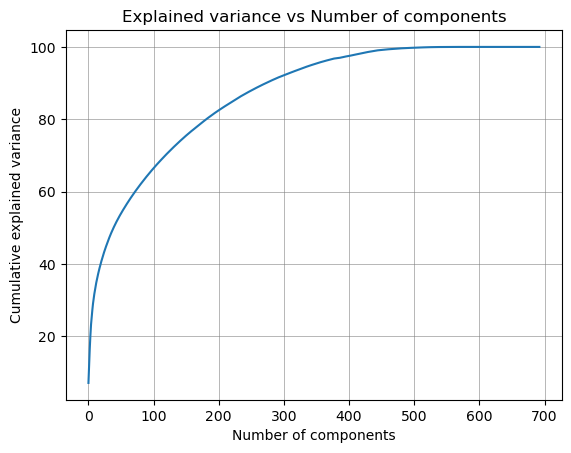

In [107]:
plt.title("Explained variance vs Number of components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(len(cumulative_variance_explained)), cumulative_variance_explained)

plt.show()
#plt.savefig('Explained variance.png')

In [108]:
K = 400 # more or less like adhesin
print('Principal components:', K)
print('Discarded components:', columns-K)

Principal components: 400
Discarded components: 293


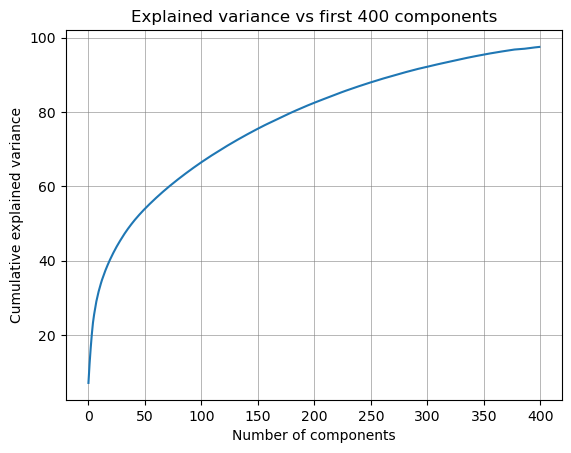

In [109]:
plt.title("Explained variance vs first " + str(K) + " components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(K), cumulative_variance_explained[:K])

plt.show()
#plt.savefig('Explained variance.png')

In [110]:
# Project using first K components

projection_matrix = numpy.real((eigen_vectors.T[:][:K]).T)
print(projection_matrix.shape)

numpy.save('projection_matrix', projection_matrix)

(693, 400)


In [111]:
# project matrices
X_train = stdX.dot(projection_matrix)
X_val = stdX_val.dot(projection_matrix)
X_test = stdX_test.dot(projection_matrix)

In [112]:
X_train.shape


(1814, 400)

In [113]:
X_val.shape

(907, 400)

In [114]:
X_test.shape

(907, 400)

In [115]:
X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)
X.shape


(3628, 400)

In [116]:
y.shape

(3628,)

In [129]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Definisci la classe della rete neurale
class NeuralNetwork:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(units=10, activation='sigmoid', input_shape=(K,)),
            Dense(units=1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', 'mse', 'recall', 'precision'])
        return model

# Definisci il numero di fold per la cross-validation
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Inizializza una lista per salvare gli score di validazione per ogni fold
val_accuracy_cv = []
val_recall_cv = []
val_precision_cv = []

# Itera attraverso i fold della cross-validation
for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Inizializza e addestra la rete neurale
    nn = NeuralNetwork()
    history = nn.model.fit(
        x=X_train_fold, 
        y=y_train_fold,
        batch_size=64,
        epochs=1000,
        verbose=1,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[EarlyStopping(restore_best_weights=True, patience=20)]
    )
    
    # Valuta la rete neurale sul fold di validazione
    val_loss, val_accuracy, val_mse, val_recall, val_precision = nn.model.evaluate(X_val_fold, y_val_fold)
  
    

    
    val_accuracy_cv.append(val_accuracy)
    val_recall_cv.append(val_recall)
    val_precision_cv.append(val_precision)

# Calcola e stampa l'accuracy media dei fold di validazione
mean_val_accuracy = np.mean(val_accuracy_cv)
mean_val_recall = np.mean(val_recall_cv)
mean_val_precision = np.mean(val_precision_cv)
print("Mean Validation Accuracy:", mean_val_accuracy)
print("Mean Validation recall:", mean_val_recall)
print("Mean Validation precision:", mean_val_precision)

print("accuracy:", val_accuracy_cv)
print("recall:", val_recall_cv)
print("precision:", val_precision_cv)

Epoch 1/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6330 - loss: 0.6515 - mse: 0.2296 - precision: 0.6523 - recall: 0.5700 - val_accuracy: 0.6901 - val_loss: 0.6114 - val_mse: 0.2106 - val_precision: 0.7412 - val_recall: 0.6305
Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.7457 - loss: 0.5673 - mse: 0.1902 - precision: 0.7789 - recall: 0.6576 - val_accuracy: 0.7215 - val_loss: 0.5726 - val_mse: 0.1932 - val_precision: 0.7733 - val_recall: 0.6651
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.7821 - loss: 0.5103 - mse: 0.1652 - precision: 0.8220 - recall: 0.7170 - val_accuracy: 0.7347 - val_loss: 0.5477 - val_mse: 0.1828 - val_precision: 0.7890 - val_recall: 0.6761
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.8109 - loss: 0.4724 - mse: 0.1499 - precision: 0.8411 - recall: 0.7549 - val_accuracy: 0.7430 - val_loss: 0.5331 - val_mse: 0.1772 - val_precision: 0.7939 - val_recall: 0.6903
Epoch 5/1000
38/38 ━━━━━━━

Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.6124 - loss: 0.6368 - mse: 0.2238 - precision: 0.5748 - recall: 0.9008 - val_accuracy: 0.6609 - val_loss: 0.6165 - val_mse: 0.2138 - val_precision: 0.6097 - val_recall: 0.8382
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.7237 - loss: 0.5687 - mse: 0.1917 - precision: 0.6850 - recall: 0.8527 - val_accuracy: 0.7138 - val_loss: 0.5758 - val_mse: 0.1950 - val_precision: 0.6754 - val_recall: 0.7905
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7712 - loss: 0.5256 - mse: 0.1720 - precision: 0.7639 - recall: 0.8198 - val_accuracy: 0.7378 - val_loss: 0.5488 - val_mse: 0.1832 - val_precision: 0.7103 - val_recall: 0.7768
Epoch 5/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.8012 - loss: 0.4993 - mse: 0.1607 - precision: 0.7965 - recall: 0.8022 - val_accuracy: 0.7552 - val_loss: 0.5293 - val_mse: 0.1750 - val_precision: 0.7381 - val_recall: 0.7683
Epoch 6/1000
38/38 ━━━━━

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.9008 - loss: 0.2700 - mse: 0.0783 - precision: 0.9087 - recall: 0.8968 - val_accuracy: 0.7775 - val_loss: 0.5173 - val_mse: 0.1640 - val_precision: 0.7704 - val_recall: 0.7717
Epoch 32/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.9007 - loss: 0.2771 - mse: 0.0809 - precision: 0.9060 - recall: 0.9006 - val_accuracy: 0.7775 - val_loss: 0.5184 - val_mse: 0.1641 - val_precision: 0.7695 - val_recall: 0.7734
Epoch 33/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.9120 - loss: 0.2618 - mse: 0.0743 - precision: 0.9195 - recall: 0.9067 - val_accuracy: 0.7783 - val_loss: 0.5201 - val_mse: 0.1643 - val_precision: 0.7708 - val_recall: 0.7734
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - accuracy: 0.7887 - loss: 0.4703 - mse: 0.1520 - precision: 0.7993 - recall: 0.7837
Epoch 1/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5433 - loss: 0.6919 - mse: 0.2493 - precision: 0.5901 - recall: 0.3526 - val_accuracy: 

Epoch 27/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.8854 - loss: 0.2844 - mse: 0.0832 - precision: 0.9005 - recall: 0.8735 - val_accuracy: 0.7527 - val_loss: 0.5372 - val_mse: 0.1741 - val_precision: 0.7443 - val_recall: 0.7605
Epoch 28/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.8822 - loss: 0.2934 - mse: 0.0868 - precision: 0.8969 - recall: 0.8645 - val_accuracy: 0.7552 - val_loss: 0.5399 - val_mse: 0.1747 - val_precision: 0.7463 - val_recall: 0.7638
Epoch 29/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.8898 - loss: 0.2837 - mse: 0.0832 - precision: 0.8972 - recall: 0.8823 - val_accuracy: 0.7502 - val_loss: 0.5439 - val_mse: 0.1758 - val_precision: 0.7398 - val_recall: 0.7621
Epoch 30/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.8868 - loss: 0.2859 - mse: 0.0843 - precision: 0.8904 - recall: 0.8865 - val_accuracy: 0.7502 - val_loss: 0.5471 - val_mse: 0.1764 - val_precision: 0.7398 - val_recall: 0.7621
38/38 ━━━━━━━━━━━━━━

In [79]:
val_accuracy_cv

[0.7528925538063049, 0.7775020599365234, 0.7659222483634949]

In [13]:
from tensorflow.keras import regularizers

class neural_network:
    def __init__(self):
        input = tensorflow.keras.Input(shape=(K,))

        dense = tensorflow.keras.layers.Dense(units=10, activation='sigmoid')(input) # it shows that a linear activation is sufficiet to get the same accuracy of the sigmoid (so it's like a matrix multiplication with a non-linearity at the end...)
        #batch = tensorflow.keras.layers.BatchNormalization()(dense)
        #activation = tensorflow.keras.activations.sigmoid(batch)
        #drop = tensorflow.keras.layers.Dropout(.1)(activation)

        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'mse', 'recall'])
        self.model = model

In [14]:
nn = neural_network()

2024-04-23 22:27:35.684753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 22:27:35.685138: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
history = nn.model.fit(
    x=X_train, 
    y=y_train,
    batch_size=64,
    epochs=1000,
    verbose=1,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=20
        )]
)

Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5200 - loss: 0.7082 - mse: 0.2565 - recall: 0.1950 - val_accuracy: 0.5623 - val_loss: 0.6820 - val_mse: 0.2445 - val_recall: 0.2615
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.5561 - loss: 0.6890 - mse: 0.2475 - recall: 0.2615 - val_accuracy: 0.5700 - val_loss: 0.6762 - val_mse: 0.2417 - val_recall: 0.2775
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.5714 - loss: 0.6830 - mse: 0.2445 - recall: 0.2706 - val_accuracy: 0.5722 - val_loss: 0.6704 - val_mse: 0.2390 - val_recall: 0.2913
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.5723 - loss: 0.6803 - mse: 0.2433 - recall: 0.3021 - val_accuracy: 0.5788 - val_loss: 0.6648 - val_mse: 0.2363 - val_recall: 0.3119
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.5809 - loss: 0.6744 - mse: 0.2405 - recall: 0.3093 - val_accuracy: 0.5877 - val_loss: 0.6594 - val_mse: 0.2337 - val_recall: 0.3234
Ep

Epoch 36/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7920 - loss: 0.5205 - mse: 0.1686 - recall: 0.7252 - val_accuracy: 0.7475 - val_loss: 0.5498 - val_mse: 0.1826 - val_recall: 0.6812
Epoch 37/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.7957 - loss: 0.5138 - mse: 0.1658 - recall: 0.7531 - val_accuracy: 0.7519 - val_loss: 0.5476 - val_mse: 0.1816 - val_recall: 0.6904
Epoch 38/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.7946 - loss: 0.5149 - mse: 0.1664 - recall: 0.7420 - val_accuracy: 0.7508 - val_loss: 0.5454 - val_mse: 0.1807 - val_recall: 0.6927
Epoch 39/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.7993 - loss: 0.5062 - mse: 0.1625 - recall: 0.7503 - val_accuracy: 0.7486 - val_loss: 0.5433 - val_mse: 0.1798 - val_recall: 0.6950
Epoch 40/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.8023 - loss: 0.5039 - mse: 0.1614 - recall: 0.7570 - val_accuracy: 0.7519 - val_loss: 0.5412 - val_mse: 0.1789 - val_recall: 0.

Epoch 71/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.8340 - loss: 0.4407 - mse: 0.1361 - recall: 0.8110 - val_accuracy: 0.7696 - val_loss: 0.4984 - val_mse: 0.1618 - val_recall: 0.7385
Epoch 72/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.8296 - loss: 0.4230 - mse: 0.1289 - recall: 0.7895 - val_accuracy: 0.7718 - val_loss: 0.4975 - val_mse: 0.1615 - val_recall: 0.7408
Epoch 73/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.8402 - loss: 0.4190 - mse: 0.1273 - recall: 0.8160 - val_accuracy: 0.7729 - val_loss: 0.4966 - val_mse: 0.1612 - val_recall: 0.7431
Epoch 74/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.8387 - loss: 0.4184 - mse: 0.1270 - recall: 0.8134 - val_accuracy: 0.7729 - val_loss: 0.4959 - val_mse: 0.1609 - val_recall: 0.7431
Epoch 75/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.8416 - loss: 0.4170 - mse: 0.1265 - recall: 0.8185 - val_accuracy: 0.7740 - val_loss: 0.4952 - val_mse: 0.1607 - val_recall: 0.

Epoch 106/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.8572 - loss: 0.3744 - mse: 0.1115 - recall: 0.8452 - val_accuracy: 0.7806 - val_loss: 0.4818 - val_mse: 0.1561 - val_recall: 0.7546
Epoch 107/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.8575 - loss: 0.3700 - mse: 0.1100 - recall: 0.8366 - val_accuracy: 0.7784 - val_loss: 0.4816 - val_mse: 0.1561 - val_recall: 0.7523
Epoch 108/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.8616 - loss: 0.3726 - mse: 0.1113 - recall: 0.8324 - val_accuracy: 0.7806 - val_loss: 0.4815 - val_mse: 0.1560 - val_recall: 0.7523
Epoch 109/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.8552 - loss: 0.3742 - mse: 0.1121 - recall: 0.8371 - val_accuracy: 0.7817 - val_loss: 0.4812 - val_mse: 0.1559 - val_recall: 0.7546
Epoch 110/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.8647 - loss: 0.3654 - mse: 0.1081 - recall: 0.8419 - val_accuracy: 0.7806 - val_loss: 0.4810 - val_mse: 0.1559 - val_recal

Epoch 141/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.8784 - loss: 0.3321 - mse: 0.0972 - recall: 0.8618 - val_accuracy: 0.7751 - val_loss: 0.4806 - val_mse: 0.1558 - val_recall: 0.7477
Epoch 142/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.8802 - loss: 0.3360 - mse: 0.0988 - recall: 0.8663 - val_accuracy: 0.7751 - val_loss: 0.4807 - val_mse: 0.1558 - val_recall: 0.7477


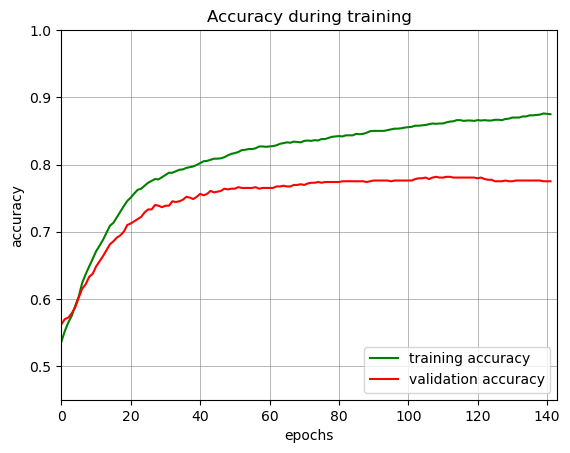

In [16]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

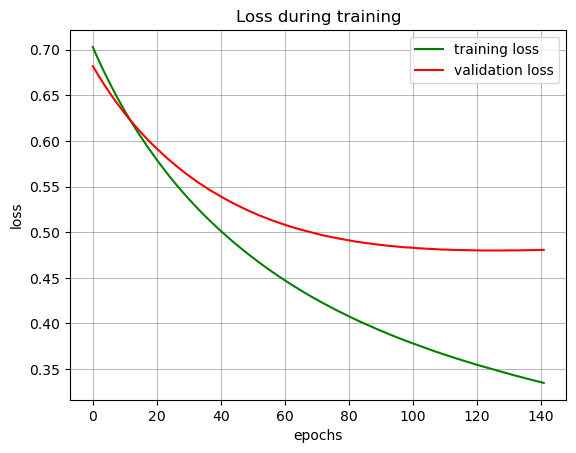

In [17]:
plt.title('Loss during training')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training loss', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='validation loss', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('loss.png')

In [18]:
nn.model.evaluate(x=X_test, y=y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.7469 - loss: 0.5177 - mse: 0.1726 - recall: 0.7003


[0.5166293978691101,
 0.7497243881225586,
 0.17164233326911926,
 0.7199124693870544]

In [19]:
nn.model.save('vcm.h5')

### Check performace on negative and positive classes

In [20]:
'''
pos_dataset_test = [[] for array in range(len(datasets_test))]
for array in range(len(datasets_test)):
    for item, i in zip(datasets_test[array], y_test):
        if i == 1:
            pos_dataset_test[array].append(list(item))
for i in range(5):
    pos_dataset_test[i]=numpy.array(pos_dataset_test[i])
y_pos_test = numpy.array([1. for _ in range(len(pos_dataset_test[0]))])

neg_dataset_test = [[] for array in range(len(datasets_test))]
for array in range(len(datasets_test)):
    for item, i in zip(datasets_test[array], y_test):
        if i == 0:
            neg_dataset_test[array].append(list(item))
for i in range(5):
    neg_dataset_test[i]=numpy.array(neg_dataset_test[i])
y_neg_test = numpy.array([0. for _ in range(len(neg_dataset_test[0]))])

pos_perf = nn.model.evaluate(x=pos_dataset_test, y=y_pos_test)
neg_perf = nn.model.evaluate(x=neg_dataset_test, y=y_neg_test)
print('Accuracy on POSITIVE classes:', pos_perf[1])
print('Accuracy on NEGATIVE classes:', neg_perf[1])

'''

"\npos_dataset_test = [[] for array in range(len(datasets_test))]\nfor array in range(len(datasets_test)):\n    for item, i in zip(datasets_test[array], y_test):\n        if i == 1:\n            pos_dataset_test[array].append(list(item))\nfor i in range(5):\n    pos_dataset_test[i]=numpy.array(pos_dataset_test[i])\ny_pos_test = numpy.array([1. for _ in range(len(pos_dataset_test[0]))])\n\nneg_dataset_test = [[] for array in range(len(datasets_test))]\nfor array in range(len(datasets_test)):\n    for item, i in zip(datasets_test[array], y_test):\n        if i == 0:\n            neg_dataset_test[array].append(list(item))\nfor i in range(5):\n    neg_dataset_test[i]=numpy.array(neg_dataset_test[i])\ny_neg_test = numpy.array([0. for _ in range(len(neg_dataset_test[0]))])\n\npos_perf = nn.model.evaluate(x=pos_dataset_test, y=y_pos_test)\nneg_perf = nn.model.evaluate(x=neg_dataset_test, y=y_neg_test)\nprint('Accuracy on POSITIVE classes:', pos_perf[1])\nprint('Accuracy on NEGATIVE classes:',

In [46]:
# Evaluate prediction distributions
predictions = nn.model.predict(X_test)
ground_truth = y_test

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


In [47]:
# get true and false negative and positives
results = numpy.c_[predictions, ground_truth]
TP = results[numpy.where(((results[:,1] == 1) & (results[:,0] > .50)))]
TN = results[numpy.where((results[:,1] == 0) & (results[:,0] < .50))]
FP = results[numpy.where(((results[:,1] == 0) & (results[:,0] > .50)))]
FN = results[numpy.where((results[:,1] == 1) & (results[:,0] < .50))]

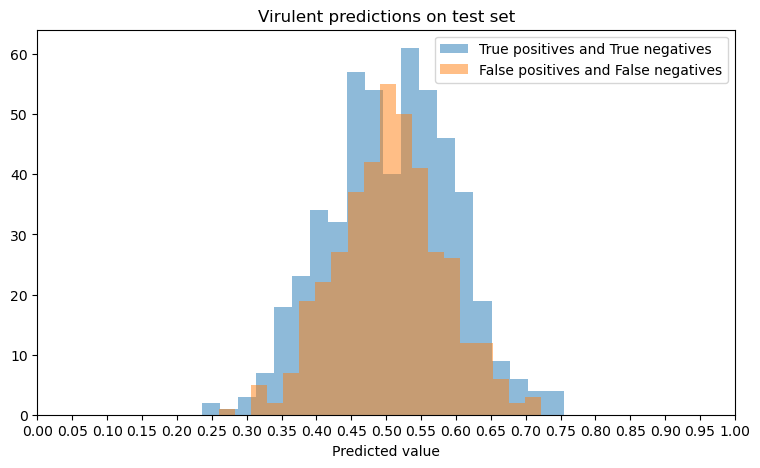

In [48]:
plt.figure(figsize=[9,5])
plt.hist(numpy.append(TP[:,0], TN[:,0]), bins=20, alpha=0.5, label = 'True positives and True negatives')
plt.hist(numpy.append(FP[:,0], FN[:,0]), bins=20, alpha=0.5, label = 'False positives and False negatives')
plt.xticks(numpy.arange(0, 1.05, step=0.05))
plt.legend()
plt.title('Virulent predictions on test set')
plt.xlabel('Predicted value')
plt.show()

In [49]:
accuracy = (len(TP) + len(TN)) / len(results)
sensitivity = len(TP) / (len(TP) + len(FN))
precision = len(TP) / (len(TP) + len(FP))
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
FPR = len(FP) / (len(FP) + len(TN))
FNR = len(FN)/ (len(TP)+len(FN))
TNR = len(TN)/(len(TN)+len(FP))
FDR = len(FP)/(len(FP)+len(TP))
TPR = len(TP)/(len(TP)+len(FN))
NPV = len(TN)/(len(TN)+len(FN))

print("Accuracy:", accuracy)
print("Sensitivity (Recall):", sensitivity)
print("Precision:", precision)
print("F1-score:", f1_score)
print("False Positive Rate (FPR):", FPR)
print("False Negative Rate (FNR):", FNR)
print("True Negative Rate (TNR):", TNR)
print("False Discovery Rate (FDR):", FDR)
print("True Positive Rate (FDR):", TPR)
print("Negative Predictive Value (NPV):", NPV)


Accuracy: 0.5633958103638368
Sensitivity (Recall): 0.5973741794310722
Precision: 0.5628865979381443
F1-score: 0.5796178343949044
False Positive Rate (FPR): 0.4711111111111111
False Negative Rate (FNR): 0.4026258205689278
True Negative Rate (TNR): 0.5288888888888889
False Discovery Rate (FDR): 0.43711340206185567
True Positive Rate (FDR): 0.5973741794310722
Negative Predictive Value (NPV): 0.5639810426540285


In [50]:
from sklearn.metrics import confusion_matrix

y_pred_class = predictions > 0.51
cm = confusion_matrix(ground_truth, y_pred_class)
TN, FP, FN, TP = cm.ravel()

In [51]:
cm

array([[264, 186],
       [200, 257]])

In [52]:
cm.ravel()

array([264, 186, 200, 257])

In [53]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
confusion_matrix = metrics.confusion_matrix(ground_truth, y_pred_class)

In [55]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not vir", "vir"])

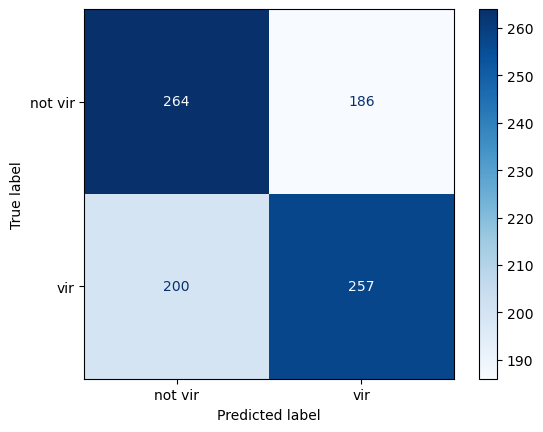

In [56]:
cm_display.plot(cmap='Blues')
plt.show()

In [57]:
num_ones = np.count_nonzero(ground_truth == 1)
num_zeros = np.count_nonzero(ground_truth == 0)

print("Numero di valori uguali a 1:", num_ones)
print("Numero di valori uguali a 0:", num_zeros)

Numero di valori uguali a 1: 457
Numero di valori uguali a 0: 450


In [58]:
sum(ground_truth==0)

450

In [59]:
import pandas as pd

# Creazione del dizionario contenente le metriche
metrics_dict = {
    "Metrica": ["Accuracy", "Sensitivity (Recall)", "Precision", "F1-score", 
                "False Positive Rate (FPR)", "False Negative Rate (FNR)",
                "True Negative Rate (TNR)", "False Discovery Rate (FDR)",
                "True Positive Rate (FDR)", "Negative Predictive Value (NPV)"],
    "Valore": [0.7508269018743109, 0.7242888402625821, 0.7679814385150812, 0.7454954954954955,
               0.2222222222222222, 0.27571115973741794, 0.7777777777777778, 0.23201856148491878,
               0.7242888402625821, 0.7352941176470589]
}

# Creazione del DataFrame pandas
metrics_df = pd.DataFrame(metrics_dict)

# Stampa del DataFrame
print(metrics_df)

# Salvataggio del DataFrame in un file CSV
metrics_df.to_csv("metrics_vir050.csv", index=False)


                           Metrica    Valore
0                         Accuracy  0.750827
1             Sensitivity (Recall)  0.724289
2                        Precision  0.767981
3                         F1-score  0.745495
4        False Positive Rate (FPR)  0.222222
5        False Negative Rate (FNR)  0.275711
6         True Negative Rate (TNR)  0.777778
7       False Discovery Rate (FDR)  0.232019
8         True Positive Rate (FDR)  0.724289
9  Negative Predictive Value (NPV)  0.735294
